## Лабораторная 3

Вариант 7. Экономика стран

Бизнес-цели:
1) прогнозирование уровня инфляции на основе данных за года
2) определение факторов, значительно влияющих на показателль ВВП на душу населения

Технические цели:
1) Разработать МО для прогнозирования уровня инфляции на основе исторических данных
2) Проанализировать взаимосвязь между экономическими показателями и ВВП

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(".//csv//EconomicData.csv")
print(df.columns)

Index(['stock index', 'country', 'year', 'index price', 'log_indexprice',
       'inflationrate', 'oil prices', 'exchange_rate', 'gdppercent',
       'percapitaincome', 'unemploymentrate', 'manufacturingoutput',
       'tradebalance', 'USTreasury'],
      dtype='object')


Подготовка данных:

In [75]:
print(df.isnull().sum())

stock index             0
country                 0
year                    0
index price            52
log_indexprice          0
inflationrate          43
oil prices              0
exchange_rate           2
gdppercent             19
percapitaincome         1
unemploymentrate       21
manufacturingoutput    91
tradebalance            4
USTreasury              0
dtype: int64


Заполним пустые значения медианами:

In [76]:
for column in df.columns:
    if (column != "stock index" and column != "country"):
        df[column].fillna(df[column].median())

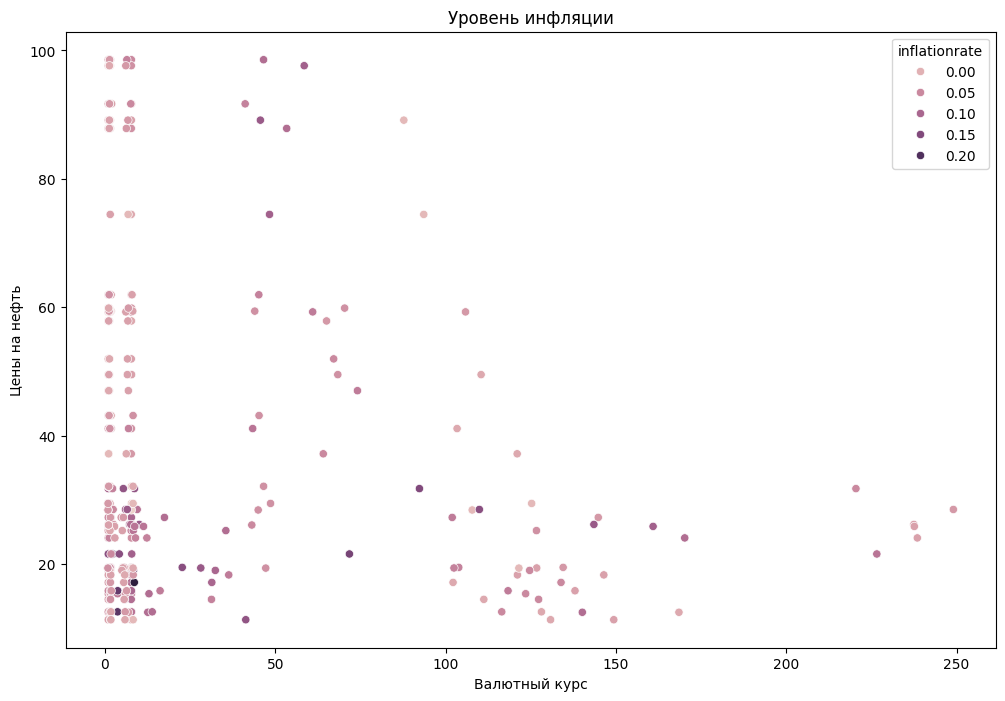

In [77]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x='exchange_rate', y='oil prices', hue='inflationrate', data=df)
plt.title('Уровень инфляции')
plt.xlabel('Валютный курс')
plt.ylabel('Цены на нефть')
plt.legend(title='inflationrate')
plt.show()

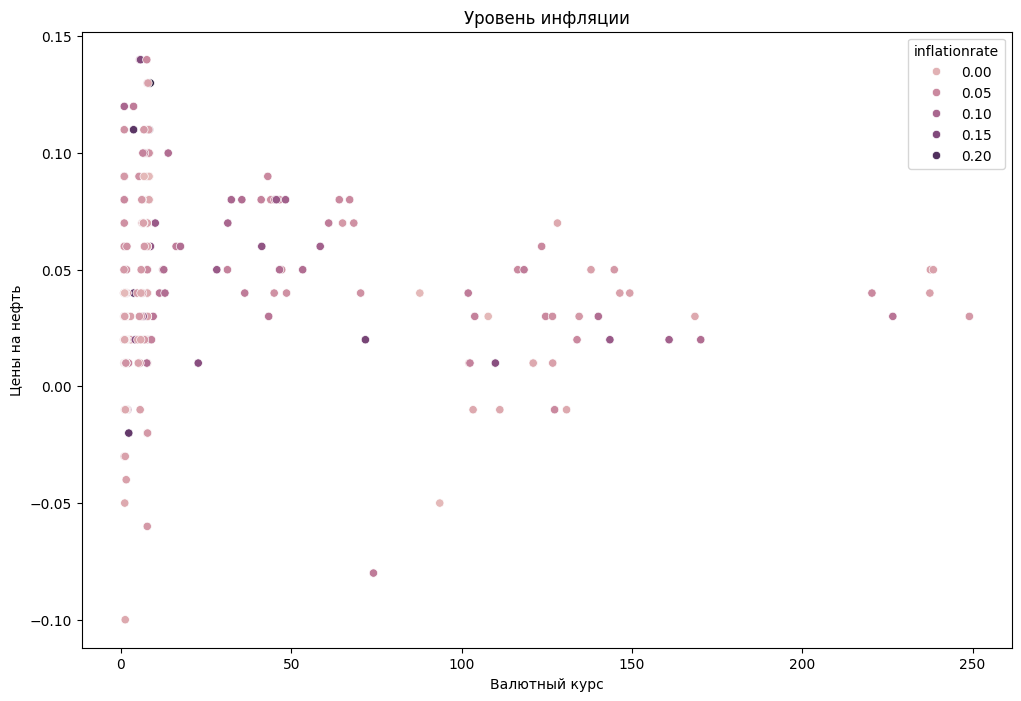

In [78]:
Q1 = df['oil prices'].quantile(0.25)
Q3 = df['oil prices'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5 * IQR
outliers = (df['oil prices'] < (Q1 - threshold)) | (df['oil prices'] > (Q3 + threshold))

median_rating = df['oil prices'].median()
df.loc[outliers, 'oil prices'] = median_rating

plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x='exchange_rate', y='gdppercent', hue='inflationrate', data=df)
plt.title('Уровень инфляции')
plt.xlabel('Валютный курс')
plt.ylabel('Цены на нефть')
plt.legend(title='inflationrate')
plt.show()

Разбиение данных на выборки и оценка сбалансированности выборки

In [79]:
from sklearn.model_selection import train_test_split

# обучающая и тестовая
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# обучающая на обучающую и контрольную
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print("Размер обучающей выборки:", len(train_df))
print("Размер контрольной выборки:", len(val_df))
print("Размер тестовой выборки:", len(test_df))

Размер обучающей выборки: 221
Размер контрольной выборки: 74
Размер тестовой выборки: 74


Конструирование признаков

1) Кодирование категориальных признаков

In [80]:
from sklearn.preprocessing import OneHotEncoder

df = pd.get_dummies(df, columns=['country'])
print(df.head)

<bound method NDFrame.head of     stock index    year  index price  log_indexprice  inflationrate  \
0        NASDAQ  1980.0       168.61            2.23           0.14   
1        NASDAQ  1981.0       203.15            2.31           0.10   
2        NASDAQ  1982.0       188.98            2.28           0.06   
3        NASDAQ  1983.0       285.43            2.46           0.03   
4        NASDAQ  1984.0       248.89            2.40           0.04   
..          ...     ...          ...             ...            ...   
364      IEX 35  2016.0      9352.10            3.97            NaN   
365      IEX 35  2017.0     10043.90            4.00           0.02   
366      IEX 35  2018.0      8539.90            3.93           0.02   
367      IEX 35  2019.0      9549.20            3.98           0.01   
368      IEX 35  2020.0      8073.70            3.91            NaN   

     oil prices  exchange_rate  gdppercent  percapitaincome  unemploymentrate  \
0         21.59           1.00      

2. Дискретизация числовых признаков

In [88]:
print(f"min = {df['percapitaincome'].min()}")
print(f"max = {df['percapitaincome'].max()}")
print(df['percapitaincome'].max()/6)

min = 27.0
max = 65280.0
10880.0


In [92]:
from sklearn.preprocessing import KBinsDiscretizer

bins = [0, 11000, 22000, 33000, 44000, float('inf')]
labels = ['незначительный', 'низкий', 'средний', 'высокий', 'очень высокий']

df['percapitaincome_level'] = pd.cut(df['percapitaincome'], bins=bins, labels=labels)
print(df['percapitaincome_level'].head)

<bound method NDFrame.head of 0       низкий
1       низкий
2       низкий
3       низкий
4       низкий
        ...   
364    средний
365    средний
366    средний
367    средний
368    средний
Name: percapitaincome_level, Length: 369, dtype: category
Categories (5, object): ['незначительный' < 'низкий' < 'средний' < 'высокий' < 'очень высокий']>


3) Ручной синтез признаков

In [95]:
# pip install featuretools
import featuretools as ft

es = ft.EntitySet(id='economy_data')
es.add_dataframe(
    dataframe=df,
    dataframe_name='economy',
    index='index',
    make_index=True
)

# Автоматическое конструирование
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name='economy',
    agg_primitives=['mean', 'sum', 'max', 'min', 'std'],
    trans_primitives=['add_numeric', 'multiply_numeric'],
    max_depth=2 
)

print("Сгенерированные признаки:")
print(feature_matrix.head())
print("\nОписание:")
print(feature_defs)

e:\AIM1.5\Scripts\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
e:\AIM1.5\Scripts\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
e:\AIM1.5\Scripts\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
e:\AIM1.5\Scripts\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be c

Сгенерированные признаки:
      stock index    year  index price  log_indexprice  inflationrate  \
index                                                                   
0          NASDAQ  1980.0       168.61            2.23           0.14   
1          NASDAQ  1981.0       203.15            2.31           0.10   
2          NASDAQ  1982.0       188.98            2.28           0.06   
3          NASDAQ  1983.0       285.43            2.46           0.03   
4          NASDAQ  1984.0       248.89            2.40           0.04   

       oil prices  exchange_rate  gdppercent  percapitaincome  \
index                                                           
0           21.59            1.0        0.09            12575   
1           31.77            1.0        0.12            13976   
2           28.52            1.0        0.04            14434   
3           26.19            1.0        0.09            15544   
4           25.88            1.0        0.11            17121   

      

4. Масштабирование

In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
df[['index price_scaled', 'log_indexprice_scaled']] = scaler_minmax.fit_transform(df[['index price', 'log_indexprice']])

Оценка качества наборов признаков:
Набор данных достаточно полный, но требует предварительной обработки (заполнение пропусков, удаление выбросов, нормализация). После обработки он может быть использован для анализа и построения моделей.